In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from skimage import feature
from imutils import build_montages
from imutils import paths
import numpy as np
import cv2
import os
import pickle
import matplotlib.pyplot as plt
import random
from keras.models import load_model

In [2]:
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=1b5b656e2f8e7cca027662b397127b6dc894e92b50ea8af838d27c4dccf41ae4
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/4b/a5/2d/4a070a801d3a3d93f033d3ee9728f470f514826e89952df3ea
Successfully built imutils


In [4]:
def quantify_image(image):
    features = feature.hog(image,orientations = 9, pixels_per_cell = (10,10), cells_per_block = (2,2),transform_sqrt=True, block_norm = "L1")
    return features

In [5]:
def load_split(path):
    imagePaths = list(paths.list_images(path))
    data = []
    labels = []
    
    for imagePath in imagePaths:
        label = imagePath.split(os.path.sep)[-2]
        
        
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image,(200,200))
        
        
        image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        
        features = quantify_image(image)
       
        data.append(features)
        labels.append(label)
        
    return(np.array(data), np.array(labels))

In [6]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='vkiwyYeh-yZBsXJtad21EBAkIRVzzYLWOr5JAMik0urI',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'parkinsondetection-donotdelete-pr-r2vrmtlgz1k4ui'
object_key = 'dataset.zip'

streaming_body_1 = cos_client.get_object(Bucket=bucket, Key=object_key)['Body']

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/


In [7]:
from io import BytesIO
import zipfile
unzip=zipfile.ZipFile(BytesIO(streaming_body_1.read()),'r')
file_paths=unzip.namelist()
for path in file_paths:
    unzip.extract(path)

In [8]:
def train_model(im):
    path = "/home/wsuser/work/dataset/" + im
    trainingPath = os.path.sep.join([path, "/training"])
    testingPath = os.path.sep.join([path, "/testing"])
    # load the data
    (trainX, trainY) = load_split(trainingPath)
    (testX, testY) = load_split(testingPath)
    # encode the labels
    le = LabelEncoder()
    trainY = le.fit_transform(trainY)
    testY = le.transform(testY)
    model=RandomForestClassifier(n_estimators=100)
    model=model.fit(trainX, trainY)
    pickle.dump(model,open('parkinson.pkl','wb')) 
    predictions = model.predict(testX)
    cm = confusion_matrix(testY, predictions).flatten()
    tn, fp, fn, tp = cm
    accuracy = (tp + tn) / float(cm.sum())
    sensitivity= tp / float(tp + fn)
    specificity = tn / float(tn + fp)
    print(accuracy)
    return model

In [9]:
def test_prediction(model, testingPath):
   
    testingPaths = list(paths.list_images(testingPath))
    output_images = []
    
    for _ in range(25):
        image = cv2.imread(random.choice(testingPaths))
        output = image.copy()
        output = cv2.resize(output, (128, 128))
        # pre-process the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))
        image = cv2.threshold(image, 0, 255,
                              cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        # quantify the image and make predictions based on the extracted features
        features = quantify_image(image)
        preds = model.predict([features])
        label = "Parkinson" if preds[0] else "Healthy"

        # draw the colored class label on the output image and add it to
        # the set of output images
        color = (0, 255, 0) if label == "Healthy" else (0, 0, 255)
        cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    color, 2)
        output_images.append(output)
    plt.figure(figsize=(20, 20))
    for i in range(len(output_images)):
        plt.subplot(5, 5, i+1)
        plt.imshow(output_images[i])
        plt.axis("off")
    plt.show()

In [10]:
spiralModels = train_model('spiral')


0.8666666666666667


In [11]:
!pip install -U ibm-watson-machine-learning
!tar -zcvf Parkinson_Disease_Detection_model.tgz parkinson.pkl

     |████████████████████████████████| 1.9 MB 10.9 MB/s eta 0:00:01
  Attempting uninstall: ibm-watson-machine-learning
    Found existing installation: ibm-watson-machine-learning 1.0.272
    Uninstalling ibm-watson-machine-learning-1.0.272:
      Successfully uninstalled ibm-watson-machine-learning-1.0.272
parkinson.pkl


In [12]:
from ibm_watson_machine_learning import APIClient
wml_credentials={"url":"https://us-south.ml.cloud.ibm.com", 
                 "apikey": "TqjVLPC1pWR6M1FhYVyZBxZ-dc5w4GVCdK_d3i8OelAQ"
                }
client=APIClient(wml_credentials)

In [13]:
def guide_from_space_name(client,space_name):
    space=client.spaces.get_details()
    return(next(item for item in space['resources']if item['entity']["name"]==space_name)['metadata']['id'])


In [14]:
space_uid=guide_from_space_name(client,'parkinson deploy')
print("Space UID =" + space_uid)

Space UID =999af70a-2382-4290-8d01-76213cf19306


In [15]:
client.set.default_space(space_uid)

'SUCCESS'

In [16]:
client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12      020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9      0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt22.2-py3.10        125b6d9

In [17]:
software_spec_uid=client.software_specifications.get_uid_by_name("runtime-22.1-py3.9")
software_spec_uid

'12b83a17-24d8-5082-900f-0ab31fbfd3cb'

In [18]:
model_details=client.repository.store_model(model='Parkinson_Disease_Detection_model.tgz',meta_props={client.repository.ModelMetaNames.NAME:"parkinson_model",client.repository.ModelMetaNames.TYPE:"scikit-learn_1.0",client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_spec_uid})
model_id=client.repository.get_model_id(model_details)

In [19]:
model_id

'858ef1f1-a8fb-4c67-8af4-b61cfdb1b8d1'

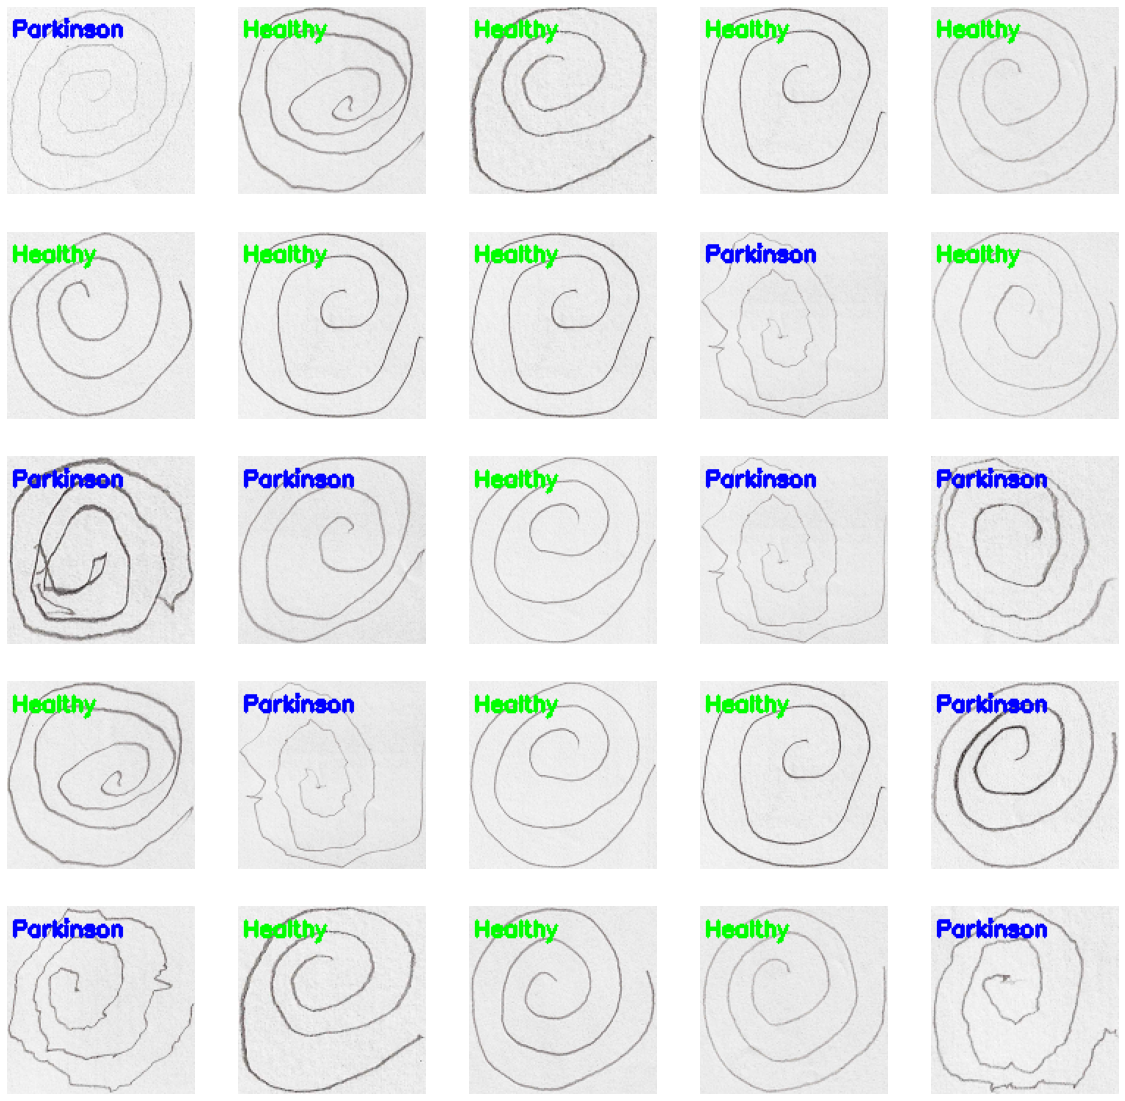

In [20]:
testingPath = os.path.sep.join(["/home/wsuser/work/dataset/spiral", "testing"])
test_prediction(spiralModels, testingPath)
